#AmeniDC
## See the cost of amenities in the District of Columbia

In [110]:
%matplotlib inline
import matplotlib
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 2 * matplotlib.rcParams['savefig.dpi']
import matplotlib.pylab as plt

In [129]:
import simplejson as json
import requests
from requests import Request, Session
from bs4 import BeautifulSoup
import re

from urlparse import urljoin
from collections import namedtuple
import sqlite3
from pyspark.sql import SQLContext

import numpy as np
import pandas as pd

#import geojson
#from geojson import Feature, Point, FeatureCollection
import pprint
pp = pprint.PrettyPrinter(indent=0)

#OpenData.DC API

Get the property sale points from http://opendata.dc.gov/datasets/2acc75ccdd954267acecb8713b2b800a_28
and store as a SQL database pandas DataFrame

In [ ]:
from ediblepickle import checkpoint

@checkpoint(key='prop_sales_json.csv', work_dir='data', refresh=False)
def request_records():
  url = 'http://opendata.dc.gov/datasets/2acc75ccdd954267acecb8713b2b800a_28.geojson'
  with requests.Session() as s:
    resp = s.get(url)
    try:
        resp.raise_for_status()
    except requests.exceptions.HTTPError as e:
        print "And you get an HTTPError:", e.message
 

  return resp.json()

@checkpoint(key='prop_sales_dataframe.csv', work_dir='data', refresh=False)
def build_records(resp_json):
  row_dicts = []
  for feats in resp_json['features']:
    # Get all the property attributes
    row = feats['properties']
    row.update(feats['geometry'])
    row_dicts.append(row)
  return pd.DataFrame(row_dicts)

if False:
  resp_json = request_records()

  df = build_records(resp_json)
  keep_cols = [u'ABTLOTCODE',u'ACCEPTCODE',u'ADDRESS1',u'ADDRESS2',u'ANNUALTAX',u'ASSESSMENT',u'BASEBUILD',u'BASELAND',
               u'CAPCURR',u'CAPPROP',u'CAREOFNAME',u'CITYSTZIP',u'CLASS3',u'CLASS3EX',u'CLASSTYPE',u'COOPUNITS',
               u'DELCODE',u'EXTRACTDAT',u'HIGHNUMBER',u'HSTDCODE',u'LANDAREA',u'LOT',u'LOWNUMBER',u'MIX1BLDPCT',u'MIX1BLDVAL',
               u'MIX1CLASS',u'MIX1LNDPCT',u'MIX1LNDVAL',u'MIX1RATE',u'MIX1TXTYPE',u'MIX2BLDPCT',u'MIX2BLDVAL',u'MIX2CLASS',
               u'MIX2LNDPCT',u'MIX2LNDVAL',u'MIX2RATE',u'MIX2TXTYPE',u'MIXEDUSE',u'NBHD',u'NEWIMPR',u'NEWLAND',u'NEWTOTAL',
               u'OBJECTID',u'OLDIMPR',u'OLDLAND',u'OLDTOTAL',u'OWNERNAME',u'OWNNAME2',u'OWNOCCT',u'PARTPART',u'PCHILDCODE',
               u'PHASEBUILD',u'PHASECYCLE',u'PHASELAND',u'PREMISEADD',u'PROPTYPE',u'QDRNTNAME',u'REASONCD',u'SALEDATE',
               u'SALEPRICE',u'SALETYPE',u'SQUARE',u'SSL',u'STREETCODE',u'STREETNAME',u'SUBNBHD',u'SUFFIX',u'TAXRATE',u'TRIGROUP',
               u'TXSALEDESC',u'UNITNUMBER',u'USECODE',u'VACLNDUSE',u'coordinates']

  df.drop((c for c in df.columns.tolist() if c not in keep_cols),axis=1,inplace=True)
  df['lat_lng'] = df['coordinates'].map(lambda row: str(row[1])+','+str(row[0]))
  df['latitude'] = df['coordinates'].map(lambda row: row[1])
  df['longitude'] = df['coordinates'].map(lambda row: row[0])
  df.drop('coordinates',axis=1,inplace=True)
  df.to_hdf('./data/df_wo_goog.hd5','df')

In [ ]:
if False:
  df = pd.read_hdf('./data/df_wo_goog.hd5','df')

# Google Maps Places API

Here, property sale locations are queried for nearby amenities. API requests were made once offline and pickled. Data for each lat_lng pair were stored as dict. 

Create a df column showing amenity_price_rating numbers for the top 20 hits within 1000m of the property

In [2]:
df = pd.read_hdf('./data/df_w_amen.hd5','df')

In [3]:
import simplejson as json
from requests import Request, Session
import pandas as pd
from multiprocessing import Pool
from ediblepickle import checkpoint
from requests_futures.sessions import FuturesSession
from collections import namedtuple

# Read in all API keys
with open("../secrets/google_secrets.json.nogit") as fh: 
  secrets = json.loads(fh.read())
google_api_key = secrets['server_api_key']

# Define amenity types of interest
AMENITY_TYPES = ['bakery','bar','cafe','grocery_or_supermarket',
  'movie_theater','park','pharmacy','restaurant','school','spa','subway_station']

Place = namedtuple('Place',['name','lat_lng','rating','price_level'])

def google_places_parser(sess,resp):
  row_list = []
  for r in resp.json()['results']:
    name = r.get('name')
    lat_lng = str(r['geometry']['location']['lat']) + ',' + str(r['geometry']['location']['lng'])
    rating = r.get('rating')
    price_level = r.get('price_level')
    row_list.append(Place(name,lat_lng,rating,price_level))
  resp.data = row_list


def get_amenities(query_str, lat_lng_series):
  ''' Given an amenity-type query string and an nd-array-like
  lat_lng_series, return a list of list of results'''

  search_url = "https://maps.googleapis.com/maps/" \
    "api/place/nearbysearch/json"
  search_payload = {"key":google_api_key,
                    "radius":1000,
                    "types":query_str}
  urls = (search_url+'?location='+lat_lng_str for lat_lng_str 
      in lat_lng_series)


  session = FuturesSession(max_workers=7)
  futures = [session.get(url,params=search_payload,
                background_callback=google_places_parser) for url in urls]
  
  return [f.result().data for f in futures]

In [9]:
if False:
  amenity = AMENITY_TYPES[10]
  df[amenity] = pd.Series(get_amenities(amenity,df['lat_lng']))
  df.to_hdf('./data/df_w_amen.hd5','df')

/opt/conda/lib/python2.7/site-packages/pandas/io/pytables.py:2577: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->[u'ABTLOTCODE', u'ACCEPTCODE', u'ADDRESS1', u'ADDRESS2', u'CAREOFNAME', u'CITYSTZIP', u'CLASS3', u'CLASSTYPE', u'DELCODE', u'EXTRACTDAT', u'HIGHNUMBER', u'HSTDCODE', u'LOT', u'LOWNUMBER', u'MIX1CLASS', u'MIX1TXTYPE', u'MIX2CLASS', u'MIX2TXTYPE', u'MIXEDUSE', u'NBHD', u'OWNERNAME', u'OWNNAME2', u'PARTPART', u'PCHILDCODE', u'PHASECYCLE', u'PREMISEADD', u'PROPTYPE', u'QDRNTNAME', u'REASONCD', u'SALEDATE', u'SALETYPE', u'SQUARE', u'SSL', u'STREETCODE', u'STREETNAME', u'SUBNBHD', u'SUFFIX', u'TRIGROUP', u'TXSALEDESC', u'UNITNUMBER', u'USECODE', u'VACLNDUSE', 'lat_lng', 'bakery', 'bar', 'cafe', 'grocery_or_supermarket', 'movie_theater', 'park', 'pharmacy', 'restaurant', 'school', 'spa', 'subway_station']]

  warnings.warn(ws, PerformanceWarning)


In [100]:
def zip_parser(x):
  z = r.split()[-1][:5]
  try:
    return int(z)
  except:
    return np.nan
  
if False:
  df['zipcode'] = df.CITYSTZIP.map(lambda r: zip_parser(r))
  df.to_hdf('./data/df_w_amen.hd5','df')

/opt/conda/lib/python2.7/site-packages/pandas/io/pytables.py:2577: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_items] [items->None]

  warnings.warn(ws, PerformanceWarning)


In [106]:
df_sub = df.dropna(axis=1)


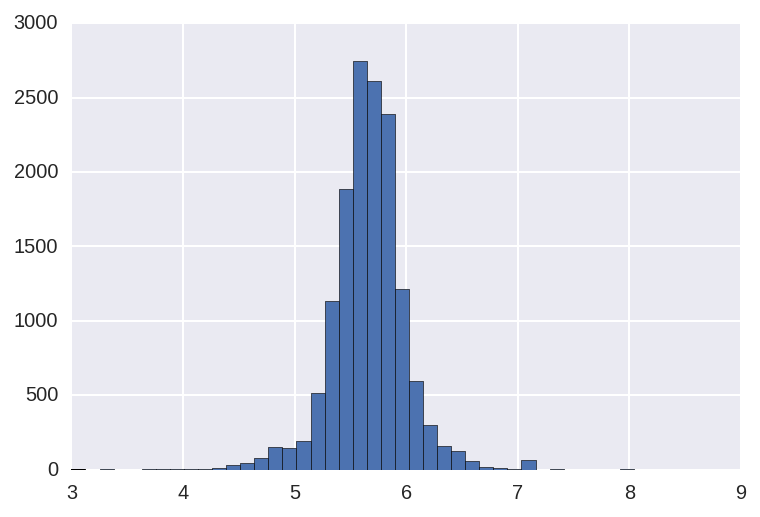

In [134]:
np.log10(df.SALEPRICE).hist(bins=40)

### Find count and mean of each amenity ###

In [181]:
def amen_mean(row,rating_or_price):
  denom = np.float64(sum(True for r in row if r[rating_or_price]))
  if denom == 0:
    return np.nan
  else:
    return sum(r[rating_or_price] for r in row if r[rating_or_price])/denom

if True:
  for amen in AMENITY_TYPES:
    df[amen+'_count'] = df[amen].map(lambda row: len(row))

    for i in xrange(2):
      if i==0:
        r_p = 'rating'
        place_ind = 2
      elif i==1:
        r_p = 'price_level'
        place_ind = 3
      else:
        print 'What are you doing?'
        continue
      df[amen+'_mean_'+r_p] = df[amen].map(lambda row: amen_mean(row,place_ind))
  
  df.to_hdf('./data/df_w_amen.hd5','df')


In [180]:
len(df.index)

14501

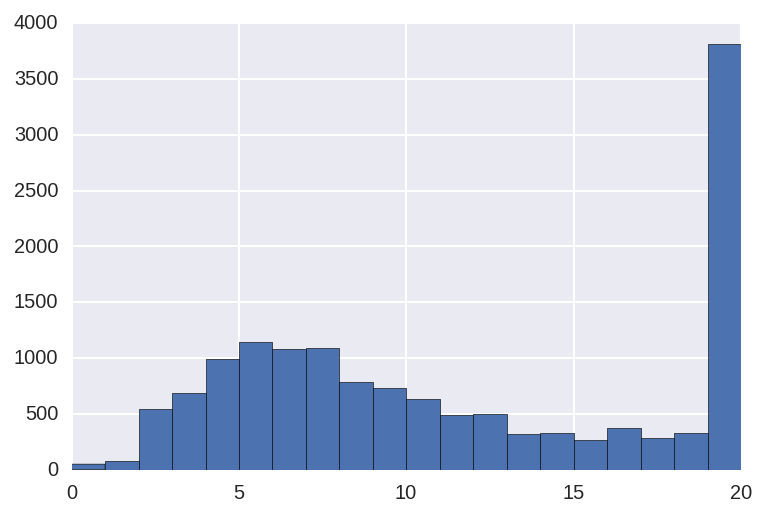

In [187]:
df.park_count.hist(bins=20)

###When places have the same name, use the haversine formula to determine if they refer to the same place.

In [ ]:
haversine(-77.020269,38.894629,-77.0325204,38.9039343)

In [ ]:
from math import radians, cos, sin, asin, sqrt
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    km = 6367 * c
    return km

In [ ]:
df[['SALEPRICE','SUBNBHD','bakery']].groupby('SUBNBHD').mean()

In [109]:
def grid_score_plotter(cv,param):
  cv_accuracy = pd.DataFrame.from_records(
      [(score.parameters[param],
        score.mean_validation_score)
       for score in cv.grid_scores_],
  columns=[param, 'accuracy'])

  plt.plot(cv_accuracy[param], cv_accuracy.accuracy)
  plt.xlabel(param)
  plt.ylabel('accuracy')
  plt.show()

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class ColumnSelectTransformer(BaseEstimator, TransformerMixin):
  """
  Select columns of data from nd array
  """
  def __init__(self, columns):
    ''' columns must be list of strings '''
    if type(columns) is list or type(columns) is str:
      self.columns = columns
    
  def fit(self, X, y):
    return self

  def transform(self, X):
    ''' Assume X is pandas dataframe'''
    return X[self.columns]
    
class ShellTransformer(BaseEstimator, TransformerMixin):
  '''Pass the fitted fitted_model into the init function
  and predict during the transform step'''
  def __init__(self,fitted_model):
    self.fitted_model = fitted_model
    pass
  
  def fit(self,X,y=None):
    return self

  def transform(self,X):
    '''Here, X is a pandas DataFrame'''
    return self.fitted_model.predict(X)
 

In [ ]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import Pipeline
from sklearn import linear_model
from sklearn import cross_validation, grid_search
import numpy as np


amen_pipe = Pipeline([
    ('select', ColumnSelectTransformer('amenities_1000')),
    ('vec', DictVectorizer(sparse=True)),
    ('ridge', linear_model.Ridge()),
])

amen_model = grid_search.GridSearchCV( amen_pipe,
                param_grid={'ridge__alpha':np.logspace(0.7,1.5,5)},
                cv=cross_validation.ShuffleSplit(len(df.index), n_iter=20, 
                    test_size=0.2, random_state=42) )

amen_model.fit(df,df['SALEPRICE'])
grid_score_plotter(amen_model,'ridge__alpha')

In [ ]:
from sklearn import neighbors

lat_lng_pipe = Pipeline([
    ('select',ColumnSelectTransformer(['latitude','longitude'])),
    ('knn', neighbors.KNeighborsRegressor())
  ])

param_grid = {"knn__n_neighbors": range(3,20)}
lat_lng_model = grid_search.GridSearchCV( lat_lng_pipe,
                param_grid=param_grid,
                cv=cross_validation.ShuffleSplit(len(df.index), n_iter=100, 
                    test_size=0.2,) )

lat_lng_model.fit(df[['latitude','longitude']],df['SALEPRICE'])

In [ ]:
for key in param_grid.keys():
  grid_score_plotter(lat_lng_model,key)

In [ ]:
amenity_types

In [ ]:
from sklearn import ensemble

lat_lng_model = grid_search.GridSearchCV( ensemble.RandomForestRegressor(n_jobs=-1),
                param_grid={"min_samples_leaf": range(1,10)},
                cv=cross_validation.ShuffleSplit(len(df.index), n_iter=20, 
                    test_size=0.2,) )

lat_lng_model.fit(df[['latitude','longitude']],df['SALEPRICE'])
grid_score_plotter(lat_lng_model,'min_samples_leaf')

In [ ]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn import linear_model
from sklearn import cross_validation, grid_search
import numpy as np


amen_pipe = Pipeline([
    ('select', ColumnSelectTransformer('amenities_1000')),
    ('vec', DictVectorizer(sparse=True)),
    ('ridge', linear_model.Ridge()),
])

amen_model = grid_search.GridSearchCV( amen_pipe,
                param_grid={'ridge__alpha':np.logspace(0.7,1.5,5)},
                cv=cross_validation.ShuffleSplit(len(df.index), n_iter=20, 
                    test_size=0.2, random_state=42) )

amen_model.fit(df,df['SALEPRICE'])
grid_score_plotter(amen_model,'ridge__alpha')